<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP problems is sequence to sequence problems(seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3fdb69af-ac3c-aa06-255a-f4704da9f92a)


## Get helper functions.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-01-19 11:04:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-19 11:04:08 (81.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get our text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data.
unzip_data("nlp_getting_started.zip")

--2025-01-19 11:04:20--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2025-01-19 11:04:20 (58.2 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do that is using Python.

But it's good we get visual straight away. Hence we're going to use pandas.

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

# Shuffle training dataFrame.

The reason we shuffle our data is to make sure our model don't have a particular format to learn(so it won't lead to baises).

In [6]:
# Shuffle our training dataset.
train_df_shuffled = train_df.sample(frac=1, random_state=42)   # frac=1 means shuffle all the data.
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataFrame look like ?.
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
## How many examples of each class are they ?.

train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [9]:
# How many total samples ?.
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples.
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index: random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
THE NATIONAL WEATHER SERVICE IN LITTLE ROCK HAS ISSUED A * SEVERE THUNDERSTORM WARNING FOR... VAN BUREN COUNTY IN Û_ http://t.co/KJsvW06GBV

---

Target: 1 (real disaster)
Text:
Refugio oil spill may have been costlier bigger than projected http://t.co/BIEYgUqpB1

---

Target: 0 (not real disaster)
Text:
@smoak_queen 'I'm going to be in so much trouble.'

---

Target: 1 (real disaster)
Text:
New Documents Found Pointing To Japan's WWII Atomic Bomb Program http://t.co/IucPcSfbMT

---

Target: 1 (real disaster)
Text:
Usama bin Ladins family dead in airplane crash. Naturally no accident.

---



### Split data into training and Validation datasets.

In [11]:
from sklearn.model_selection import train_test_split

train_sentence, val_sentence, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,   # Use 10% for validation data.
    random_state=42
)

# Check length of our sentences.
len(train_sentence), len(train_labels), len(val_sentence), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check out the first 10 samples.
train_sentence[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with text problems, one of the first things you'll have to do before you build a model is to convert your text to numbers.

There are few ways to do this, namely:
* Tokenization: directly mapping a token(a token could be a word or character) to number.
* Embedding - create a matrix of feature vector for each token



```
# This is formatted as code
```

### Text Vectorization(tokenization)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
# Use the default text vectorization parameters.
text_vectorizer = TextVectorization(
    max_tokens = 10000,   # how many words in the vocabulary. None means we don't know how many words we can have.
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,   # create groups of n-words?
    output_mode='int',   # how to map tokens to numbers
    output_sequence_length=None,   # how long do you want your sequences to be ?.
    pad_to_max_tokens=True
)

text_vectorizer

<TextVectorization name=text_vectorization, built=False>

In [14]:
train_sentence[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [15]:
# Find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentence]) / len(train_sentence))

15

In [16]:
# Setup text vectorization veriables.
max_vocab_length = 1000  # max number of words to have in our vocabulary.
max_length = 15 # max length our  sequences will be(Calculated from above).

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentence)

In [18]:
# Create a sample sentence and tokenize it.
sample_tensence = "Great i'm doing just awersome!"
text_vectorizer([sample_tensence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[196,  32, 487,  29,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose randome sentence from the training dataset and tokenize it.
random_sentence = random.choice(train_sentence)
print(f"Original text:\n {random_sentence}\
      \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 #?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/q1GlK8plUD      

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[171, 661, 247, 225,  11, 649, 432,   9,  20, 373, 242,   1,   1,
          0,   0]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 1000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['reported', 'r', 'pray', 'playlist', 'patience']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding Layer.
The parameters we care most about for our embedding layer:
   * 'input_dim' = The size of our vocabulary
   * 'output_dim' = The size of the output embedding vector, for e.g A value of 100 means each token get represented by token of 100 long.
   * 'input_length' = Length of sequences of the sequences passed to the embedding layer.
   

In [21]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128,
    input_length = max_length
)

embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [22]:
# Get a random sentence from the training set.
random_sentence = random.choice(train_sentence)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence(convert it to a embedding).Turns positive integers (indexes) into dense vectors of fixed size.
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 There's a big storm brewing dark clouds thunder and rain carrying thick dust. This could be interesting.        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00723705,  0.04764358, -0.04811226, ..., -0.00388731,
          0.0191973 , -0.02559177],
        [ 0.0021386 ,  0.02325398, -0.03314032, ..., -0.02097493,
          0.04814202, -0.04337077],
        [ 0.04430982,  0.03576677,  0.00790437, ..., -0.01814909,
          0.00788831, -0.03524985],
        ...,
        [ 0.0068322 ,  0.04561522, -0.00047828, ..., -0.01220679,
          0.03751955,  0.04061187],
        [-0.02432137,  0.03403549,  0.02052103, ..., -0.03251406,
         -0.00210226,  0.03539098],
        [ 0.01398729,  0.04567349, -0.02245594, ..., -0.040826  ,
         -0.0187253 ,  0.02278383]]], dtype=float32)>

In [23]:
# Checkout a single token embedding.
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00723705,  0.04764358, -0.04811226, -0.00654976, -0.00803592,
        -0.00222253, -0.01845215,  0.00169777,  0.01044223,  0.01201088,
         0.00091518,  0.00983179, -0.03413336,  0.04799178,  0.04949683,
        -0.02680125,  0.02213737, -0.03201853, -0.00380325,  0.04925377,
         0.03278745,  0.03094656,  0.02331238, -0.02471435, -0.00757744,
         0.00581338, -0.00842924,  0.04896835,  0.00880312, -0.04762987,
        -0.02949617, -0.03718402, -0.04635769, -0.00293288,  0.04264968,
         0.04136107,  0.01380916, -0.04891088,  0.0339479 ,  0.00582214,
        -0.01647252,  0.00623208,  0.04905554, -0.04801115,  0.02033216,
         0.04279697,  0.021388  ,  0.01224151, -0.03436958, -0.0013296 ,
         0.04028786,  0.04688955, -0.0013719 ,  0.00573802, -0.0409096 ,
         0.02299808,  0.02967269, -0.00831062, -0.00181743, -0.00614627,
        -0.03681959,  0.03105122,  0.03088042,  0.00390035, -0.00065244,
  

## Modelling a text dataset

Now we've got  way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

we'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from sklearn ML model selction.
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (usig transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these ?.andUse the standard steps in modelling with tensorflow.
  * Create a model
  * Build a model
  * Fit a model
  * Evaluate our model

In [24]:
len(train_sentence)

6851

In [25]:
len(sample_embed)

1

### Model 0: Getting a baseline.

As with all ML model experiments. it's important to create a benchmark to build a model.
To create our baseline we'll use our SKlearn Naive Bayes model..

**NB**: It's common practice to use None deep learning as our baseline(b/c of thier speed) then letter use deep learning for fine-tuning.........

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create tokenization and modelling pipeline.
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the model.
model_0.fit(train_sentence, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline trained model.
baseline_score = model_0.score(val_sentence, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [29]:
# Make predictions..
baseline_preds = model_0.predict(val_sentence)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments.

We could evaluate all of our model's prediction with different matrics. Howerver this could be combasion and can be fixed with a function.
Let's use the following modelling metrix.

  * Accuracy
  * Precision
  * Recall
  * F1-score

In [30]:
# Function to evaluate: accuracy, precision, recall and f1-score.
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
      Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy.
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }
  return model_results

In [31]:
# Get baseline results.
baseline_results = calculate_results(
    y_true = val_labels,
    y_pred = baseline_preds
)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [32]:
# Convert our results to a DataFrame.
import pandas as pd
import numpy as np
np.random.seed(42)

baseline_df = pd.DataFrame(baseline_results, index=[0])
baseline_df

,accuracy,precision,recall,f1
0,0.792651,0.811139,0.792651,0.786219


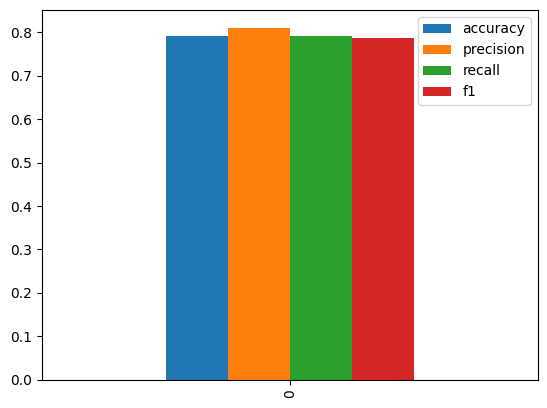

In [33]:
# Plot a bar chart.
baseline_df.plot(
    kind="bar"
);

## Model 1: A simple Dense Model

In [34]:
# Create a tensorboard callback.
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs.
SAVE_DIR = "model_logs"
tensorboard_callback = create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="baseline")


Saving TensorBoard log files to: model_logs/baseline/20250119-110431


In [35]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")  # Inputs are 1-dimensional.
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # We have binary classification, so we use sigmoid.
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")


In [36]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,129 (500.50 KB)

 Trainable params: 128,129 (500.50 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile the model.
model_1.compile(
    loss = "binary_crossentropy",           # We are working with Binary Classification
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
model_1_history = model_1.fit(
    train_sentence,
    train_labels,
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    callbacks = [tensorboard_callback]
)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6417 - loss: 0.6499 - val_accuracy: 0.7493 - val_loss: 0.5543
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7744 - loss: 0.5080 - val_accuracy: 0.7572 - val_loss: 0.5050
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8093 - loss: 0.4372 - val_accuracy: 0.7795 - val_loss: 0.4914
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8211 - loss: 0.4074 - val_accuracy: 0.7664 - val_loss: 0.4901
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8332 - loss: 0.3823 - val_accuracy: 0.7717 - val_loss: 0.4929


In [38]:
# Check the results.
model_1.evaluate(val_sentence, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - loss: 0.5145 


[0.49287381768226624, 0.7716535329818726]

In [39]:
# Make some predictions and evaluate those.
model_1_pred_probs = model_1.predict(val_sentence)
model_1_pred_probs.shape, model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((762, 1),
 array([[0.57240593],
        [0.6989439 ],
        [0.9728118 ],
        [0.2165133 ],
        [0.16969623],
        [0.9402413 ],
        [0.8681771 ],
        [0.849385  ],
        [0.7569152 ],
        [0.28904772]], dtype=float32))

In [40]:
# Convert model prediction probabilities to label format. i.e taking a prediction of above 0.5 to 1 and less than 0.5 to 0
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [41]:
# Calculate model_1 results.

model_1_preds_cpu = model_1_preds.numpy()  # If using TensorFlow

model_1_results = calculate_results(
    y_true = val_labels,
    y_pred = model_1_preds_cpu
)
model_1_results

{'accuracy': 0.7716535433070866,
 'precision': 0.7728196127186888,
 'recall': 0.7716535433070866,
 'f1': 0.7698331286570831}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer.
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(1000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
 model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,389 (1.47 MB)

 Trainable params: 128,129 (500.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,260 (1001.02 KB)

In [45]:
# Get the weight metrix of embedding layer.
# (These are a numerical representations of each token in our training data trained for 5 seconds)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights.shape  # Should be same size as vocab size and embedding_dim

(1000, 128)

### Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do this, Tensorflow has a handy tool on projecting.

To see more: https://www.tensorflow.org/text/guide/word_embeddings

In [46]:
import io

# Create embedding files(Gotting the code from tensorflow word embedding doc.)
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
# Download files from Colab to upload to projector.
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networs (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of the previous input to aid the representation of a later input

### Model 2: LSTM

LSTM = Long Short Term Memory (one of the most popular LSTM cells).

Our structure of an RNN typically looks like this:

'''
Input (text) -> Tokenize -> Embedding -> Layers -> Output (level probability)

In [48]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")  # Inputs are 1-dimensional.
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units = 64, return_sequences=True)(x)   # When you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(units = 64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)  # We have binary classification, so we use sigmoid.
model_2 = tf.keras.Model(inputs, outputs, name="model_2_dense")


(None, 64)


In [49]:
# Compile the model.
model_2.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
model_2_history = model_2.fit(
    train_sentence,
    train_labels,
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    callbacks = [tensorboard_callback]
    )

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8058 - loss: 0.4491 - val_accuracy: 0.7730 - val_loss: 0.4859
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8391 - loss: 0.3730 - val_accuracy: 0.7756 - val_loss: 0.5048
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8406 - loss: 0.3629 - val_accuracy: 0.7782 - val_loss: 0.4926
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8429 - loss: 0.3567 - val_accuracy: 0.7782 - val_loss: 0.5169
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8523 - loss: 0.3349 - val_accuracy: 0.7677 - val_loss: 0.5021


In [50]:
# Make prediction with LSTM model.
model_2_pred_probs = model_2.predict(val_sentence)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.5926726 ],
       [0.6969476 ],
       [0.930118  ],
       [0.08392759],
       [0.11722208],
       [0.9977196 ],
       [0.90735376],
       [0.7001106 ],
       [0.6347837 ],
       [0.14545505]], dtype=float32)

In [51]:
# Convert model_2_pred_prob to labels.
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate model_2 results.
model_2_preds_cpu = model_2_preds.numpy()  # If using TensorFlow

model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds_cpu)

model_2_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7732501179288073,
 'recall': 0.7677165354330708,
 'f1': 0.7638693672676267}

## Model 3. GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar faetures to an LSTM

In [53]:
=

SyntaxError: invalid syntax (<ipython-input-53-9ae22869553b>, line 1)

In [55]:
# Create a GRU model.
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 64)


In [56]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,313 (645.75 KB)

 Trainable params: 165,313 (645.75 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile our model.
model_3.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
model_3_history = model_3.fit(
    train_sentence,
    train_labels,
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    callbacks = [tensorboard_callback]
)


Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8069 - loss: 0.4384 - val_accuracy: 0.7677 - val_loss: 0.4977
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8348 - loss: 0.3725 - val_accuracy: 0.7717 - val_loss: 0.5092
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8462 - loss: 0.3541 - val_accuracy: 0.7690 - val_loss: 0.5074
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8518 - loss: 0.3394 - val_accuracy: 0.7743 - val_loss: 0.5092
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8661 - loss: 0.3270 - val_accuracy: 0.7730 - val_loss: 0.5256


In [58]:
# Making predictions with our GRU model.
model_3_pred_probs = model_3.predict(val_sentence)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([[0.5892626 ],
       [0.73582435],
       [0.9692543 ],
       [0.07573776],
       [0.22180368],
       [0.9978684 ],
       [0.79022485],
       [0.9185043 ],
       [0.78819895],
       [0.1534471 ]], dtype=float32)

In [59]:
# Convert model_3 pred_probs to labels.
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate model_3 results.

model_3_preds_to_numpy = model_3_preds.numpy()
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds_to_numpy)

model_3_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7750482481613202,
 'recall': 0.7729658792650919,
 'f1': 0.7707112186521389}

## Model 4: Building a Bidirectional RNN

Normal RNN go from Left to right(the way we read sentences).

However our Bidirectional RNN go from left-right as well as from right-left.

In [61]:
# Create a GRU model.
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Bidirectional(layers.LSTM(10, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 128)


In [62]:
# Get the summary
model_4.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 20)              │          11,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          43,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,769 (713.94 KB)

 Trainable params: 182,769 (713.94 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Compile our model.
model_4.compile(
  loss = "binary_crossentropy",
  optimizer = tf.keras.optimizers.Adam(),
  metrics = ['accuracy']
)

# Fit the model.
model_4_history = model_4.fit(
    train_sentence,
    train_labels,
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    callbacks = [tensorboard_callback]
)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8274 - loss: 0.4383 - val_accuracy: 0.7756 - val_loss: 0.5420
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8659 - loss: 0.3214 - val_accuracy: 0.7769 - val_loss: 0.6101
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8783 - loss: 0.2973 - val_accuracy: 0.7638 - val_loss: 0.5824
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8984 - loss: 0.2514 - val_accuracy: 0.7507 - val_loss: 0.6615
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8979 - loss: 0.2442 - val_accuracy: 0.7507 - val_loss: 0.7509


In [64]:
# Make predictions with our model.
model_4_pred_probs = model_4.predict(val_sentence)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


array([[0.73471314],
       [0.63422704],
       [0.99812335],
       [0.02122331],
       [0.30370697],
       [0.999358  ],
       [0.99901915],
       [0.9041323 ],
       [0.5551471 ],
       [0.06264728]], dtype=float32)

In [65]:
# Convert pred probs to pred labels.

model_4_prebs = tf.squeeze(tf.round(model_4_pred_probs))
model_4_prebs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [66]:
# calculate the results of our bidrectional model.
model_4_preds_to_numpy = model_4_prebs.numpy()
model_4_results = calculate_results(y_true = val_labels,
                                    y_pred = model_4_preds_to_numpy)

model_4_results

{'accuracy': 0.7506561679790026,
 'precision': 0.7533297744561591,
 'recall': 0.7506561679790026,
 'f1': 0.7474837243949061}

## Convolution Neural Networks for Text (and other types of sequences)

we've used CNNs for images but images are typically 2D (height and width)... however, our text data is 1D.

Previosuly we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

'''
Inputs (text) -> Tokenization -> Embedding -> Layer(s)
(typically Conv1D + pooling) -> Outputs (classification.)

## Model 5: Conv1D

In [70]:
# Test out our embedding layer, Conv1D layer and max pooling.
embedding_test = embedding(text_vectorizer(["This is a sentence"]))
conv_1d = layers.Conv1D(
    filters=32,
    kernel_size=5,
    activation="relu",
    padding="valid"
)

conv_1d_output = conv_1d(embedding_test)   # Pass text embedding through conv1D layer.
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)   # equivalent to "get the ost important feature" or "get the feature with the highest value".
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [72]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03951461,  0.02646332, -0.03787846, ...,  0.02141416,
          0.04252619,  0.03959882],
        [ 0.07874111, -0.01108368, -0.01862966, ..., -0.00576157,
         -0.0386532 , -0.03089052],
        [-0.00567347,  0.03555496, -0.0114012 , ...,  0.00721284,
          0.05164607, -0.04231995],
        ...,
        [ 0.13787983, -0.05934795, -0.01792274, ...,  0.03604873,
          0.07228345, -0.16618171],
        [ 0.13787983, -0.05934795, -0.01792274, ...,  0.03604873,
          0.07228345, -0.16618171],
        [ 0.13787983, -0.05934795, -0.01792274, ...,  0.03604873,
          0.07228345, -0.16618171]]], dtype=float32)>

In [81]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub.
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("http://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        trainable=False,
                                        name="USE"
                                        )

In [110]:

# Create a custom Keras layer to wrap the TensorFlow Hub layer
class HubLayer(layers.Layer):
    def __init__(self, handle, trainable=False, **kwargs):
        super(HubLayer, self).__init__(trainable=trainable, **kwargs)
        self.handle = handle
        self.hub_layer = hub.KerasLayer(handle, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)


# Build the model using the Functional API with the custom layer
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = HubLayer("http://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)(inputs)
outputs = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(outputs)

model_6 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_6_USE")

# Compile the model.
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hub_layer_4 (HubLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Train a classifier on top of the USE pretrained embedding.
model_6_history = model_6.fit(
    train_sentence,
    train_labels,
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    # callbacks = [tensorboard_callback]

)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.7323 - loss: 0.5801 - val_accuracy: 0.7966 - val_loss: 0.4511
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.8141 - loss: 0.4123 - val_accuracy: 0.8123 - val_loss: 0.4358
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8160 - loss: 0.4083 - val_accuracy: 0.8110 - val_loss: 0.4339
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8270 - loss: 0.3885 - val_accuracy: 0.8123 - val_loss: 0.4275
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8273 - loss: 0.3794 - val_accuracy: 0.8136 - val_loss: 0.4254


In [111]:
# Make predictions with USE TF Hub Model.
model_6_pred_probs = model_6.predict(val_sentence)
model_6_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.5055578 ],
       [0.49504834],
       [0.49807814],
       [0.49384847],
       [0.4802339 ],
       [0.5012969 ],
       [0.49810794],
       [0.50611264],
       [0.49109253],
       [0.47244284]], dtype=float32)

In [104]:
# Convert prediction probabilities to labels.
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [105]:
# Calculate model_6 performance matrix.
model_2_preds_cpu = model_2_preds.numpy()  # If using TensorFlow
model_6_results = calculate_results(y_true = val_labels,
                                     y_pred = model_2_preds_cpu)
model_6_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7732501179288073,
 'recall': 0.7677165354330708,
 'f1': 0.7638693672676267}

## Model 7: T F Hub Pretrained USE but with 10% of training data.

Transfer Learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate 'model_6' except we'll train it on 10% of the data

In [115]:
## Note: making data splits like below leads to data leakage (model_7 trained on 10% data, op)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET.
# Create a subset of 10% of the dataset.


# train_10_percent = train_df_shuffled[["text", "target"]].sample(
#     frac=0.1, random_state=42
# )
# train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [134]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentence))
train_10_percent_split = train_sentence[:train_10_percent_split]
train_labels_10_percent_split = int(0.1 * len(train_labels))
train_labels_10_percent_split = train_labels[:train_labels_10_percent_split]

685

In [116]:
# Check the number of targets in our subset of data.
train_10_percent["target"].value_counts()

,count
target,
0,413
1,348


In [117]:
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


In [124]:
# Create a custom Keras layer to wrap the TensorFlow Hub layer
class HubLayer(layers.Layer):
    def __init__(self, handle, trainable=False, **kwargs):
        super(HubLayer, self).__init__(trainable=trainable, **kwargs)
        self.handle = handle
        self.hub_layer = hub.KerasLayer(handle, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)


# Build the model using the Functional API with the custom layer
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = HubLayer("http://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)(inputs)
outputs = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(outputs)

model_7 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_7_USE")

# Compile the model.
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_7.summary()

Model: "model_7_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hub_layer_7 (HubLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:

# Train a classifier on top of the USE pretrained embedding.
model_7_history = model_7.fit(
    np.array(train_sentences_10_percent, dtype=object),
    np.array(train_labels_10_percent),
    epochs = 5,
    validation_data = (val_sentence, val_labels),
    # callbacks = [tensorboard_callback]

)
model_7.history

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5521 - loss: 0.6895 - val_accuracy: 0.7520 - val_loss: 0.6446
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7805 - loss: 0.6270 - val_accuracy: 0.7927 - val_loss: 0.5725
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7941 - loss: 0.5593 - val_accuracy: 0.8005 - val_loss: 0.5016
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7888 - loss: 0.4887 - val_accuracy: 0.8136 - val_loss: 0.4508
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8165 - loss: 0.4438 - val_accuracy: 0.8228 - val_loss: 0.4166


In [126]:
 # Evaluate the model.
 model_7_evaluate = model_7.evaluate(val_sentence, val_labels)
 model_7_evaluate

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8234 - loss: 0.4257


[0.4165787994861603, 0.8228346705436707]

In [128]:
# Make prediction.
model_7_predict = model_7.predict(val_sentence)
model_7_predict[:10]

11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.25985816],
       [0.8297427 ],
       [0.9286827 ],
       [0.35915214],
       [0.8049222 ],
       [0.84357506],
       [0.90609807],
       [0.95439076],
       [0.8315126 ],
       [0.11819414]], dtype=float32)

In [129]:
# Turn pred probs inot labels.
model_7_preds = tf.squeeze(tf.round(model_7_predict))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [132]:
# Evaluate model 7 predictions.

model_1_preds_cpu = model_1_preds.numpy()  # If using TensorFlow

model_7_results = calculate_results(
                      y_true=val_labels,
                      y_pred=model_1_preds_cpu
                      )
model_7_results

{'accuracy': 0.7716535433070866,
 'precision': 0.7728196127186888,
 'recall': 0.7716535433070866,
 'f1': 0.7698331286570831}

In [133]:
 model_6_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7732501179288073,
 'recall': 0.7677165354330708,
 'f1': 0.7638693672676267}